# Plot models

In [52]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
import glob
import os
os.chdir("/Users/luisa/Desktop/nygc/cluster/projects/fl4tsf/bin")

import json
import torch
import pandas as pd
from lib.plot import Visualizations
from lib import utils
from torch.utils.data import DataLoader
from flower.get_dataset import get_dataset, basic_collate_fn
from flower.task import Net
import matplotlib.pyplot as plt
from torch.distributions.normal import Normal
from lib.latent_ode import LatentODE
from lib.plot import plot_trajectories
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Load global model and data

In [53]:
#############################
# Load Model and Weigths
#############################

weights_file = "../results_centralized_hyperparam/periodic/centralized_training/300_epochs/lr_0.01-batchsize_16_clipping_False_lrdecay_1.0/model.pth"
#weights_file = "/Users/luisa/Desktop/nygc/cluster/projects/fl4tsf/results_federated_learningtest/periodic/federated_training/FedAvg/100_rounds/rep_1-alpha_0.5-lr_0.01-batchsize_16_clipping_False_lrdecay_1.0_localepochs_10/federated_outputs/model.pth"
weights_file = "../results_federated_learningtest/periodic/federated_training/FedAvg/100_rounds/rep_1-alpha_0.5-lr_0.001-batchsize_32_clipping_False_lrdecay_1.0_localepochs_3/federated_outputs/model.pth"
weights = torch.load(weights_file, weights_only=True)
model = Net()
model.load_state_dict(weights)

#############################
# Load Dataset
#############################
test_dataset_filename = "../data/periodic/periodic_test.pt"
time_steps_filename = "../data/periodic/periodic_time_steps.pt"
time_steps = torch.load(time_steps_filename, weights_only=True)
test_dataset = torch.load(test_dataset_filename, weights_only=True)

test_timestamps = time_steps

In [54]:
print(model)

LatentODE(
  (encoder_z0): Encoder_z0_ODE_RNN(
    (GRU_update): GRU_unit(
      (update_gate): Sequential(
        (0): Linear(in_features=42, out_features=100, bias=True)
        (1): Tanh()
        (2): Linear(in_features=100, out_features=20, bias=True)
        (3): Sigmoid()
      )
      (reset_gate): Sequential(
        (0): Linear(in_features=42, out_features=100, bias=True)
        (1): Tanh()
        (2): Linear(in_features=100, out_features=20, bias=True)
        (3): Sigmoid()
      )
      (new_state_net): Sequential(
        (0): Linear(in_features=42, out_features=100, bias=True)
        (1): Tanh()
        (2): Linear(in_features=100, out_features=40, bias=True)
      )
    )
    (z0_diffeq_solver): DiffeqSolver(
      (ode_func): ODEFunc(
        (gradient_net): Sequential(
          (0): Linear(in_features=20, out_features=100, bias=True)
          (1): Tanh()
          (2): Linear(in_features=100, out_features=100, bias=True)
          (3): Tanh()
          (4): Line

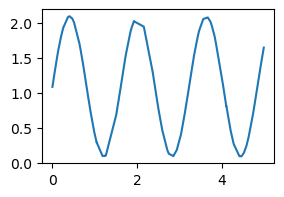

In [55]:
#############################
# Plot one example
#############################
%matplotlib inline
fig, ax = plt.subplots()
fig.set_size_inches(3, 2)
x = time_steps.squeeze()
y = test_dataset[0].squeeze()
plt.plot(x, y)
plt.show()


In [56]:
batch_size = 16

dataset_name = "periodic"
sample_tp = 0.5
cut_tp = None
extrap = False
experimentID = 10

testloader = DataLoader(test_dataset, batch_size = batch_size, shuffle=False,
	collate_fn= lambda batch: basic_collate_fn(batch, test_timestamps, dataset_name, sample_tp, cut_tp, extrap, data_type = "test"))
testloader = utils.inf_generator(testloader)
test_dict = utils.get_next_batch(testloader)

In [57]:
viz = Visualizations(device)
with torch.no_grad():
	viz.draw_all_plots_one_dim( test_dict,
								model,
								plot_name = "Test2.png",
								experimentID = 15,
								save=True)

# PLOT 

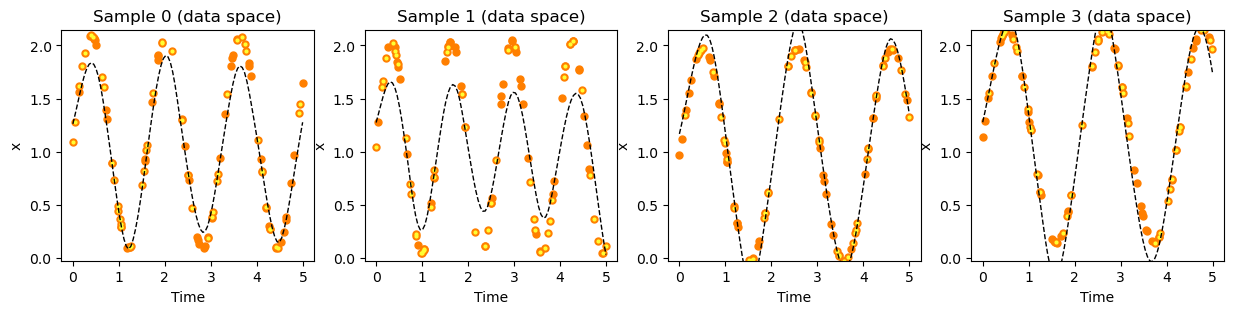

In [58]:
data =  test_dict["data_to_predict"]
time_steps = test_dict["tp_to_predict"]
mask = test_dict["mask_predicted_data"]

observed_data =  test_dict["observed_data"]
observed_time_steps = test_dict["observed_tp"]
observed_mask = test_dict["observed_mask"]

n_traj_to_show = 4

ax_traj = []
fig, ax_traj = plt.subplots(1, n_traj_to_show)
fig.set_size_inches(15, 3)

time_steps_to_predict = time_steps
if isinstance(model, LatentODE):
    # sample at the original time points
    time_steps_to_predict = utils.linspace_vector(time_steps[0], time_steps[-1], 100).to(device)

with torch.no_grad():
    reconstructions, info = model.get_reconstruction(time_steps_to_predict, 
        observed_data, observed_time_steps, mask = observed_mask, n_traj_samples = 10)

    
    # plot only 10 trajectories
    data_for_plotting = observed_data[:n_traj_to_show]
    mask_for_plotting = observed_mask[:n_traj_to_show]

    data_full = data[:n_traj_to_show]

    reconstructions_for_plotting = reconstructions.mean(dim=0)[:n_traj_to_show]
    reconstr_std = reconstructions.std(dim=0)[:n_traj_to_show]

    dim_to_show = 0
    max_y = max(
        data_for_plotting[:,:,dim_to_show].cpu().numpy().max(),
        reconstructions[:,:,dim_to_show].cpu().numpy().max())
    min_y = min(
        data_for_plotting[:,:,dim_to_show].cpu().numpy().min(),
        reconstructions[:,:,dim_to_show].cpu().numpy().min())

    ############################################
    # Plot reconstructions, true postrior and approximate posterior

    cmap = plt.colormaps['Set1']
    for traj_id in range(n_traj_to_show):

        # Plot observations
        plot_trajectories(ax_traj[traj_id], 
            data_full[traj_id].unsqueeze(0), observed_time_steps, 
            #mask = mask_for_plotting[traj_id].unsqueeze(0),
            min_y = min_y, max_y = max_y, #title="True trajectories", 
            marker = 'o', linestyle='', dim_to_show = dim_to_show, markersize= 5,
            color = cmap(4))
        # # # Plot observations
        plot_trajectories(ax_traj[traj_id], 
            data_for_plotting[traj_id].unsqueeze(0), observed_time_steps, 
            mask = mask_for_plotting[traj_id].unsqueeze(0),
            min_y = min_y, max_y = max_y, #title="True trajectories", 
            marker = 'o', linestyle='', dim_to_show = dim_to_show, add_to_plot= True, markersize= 2,
            color = cmap(5))

        # # Plot reconstructions
        plot_trajectories(ax_traj[traj_id],
            reconstructions_for_plotting[traj_id].unsqueeze(0), time_steps_to_predict, 
            min_y = min_y, max_y = max_y, title="Sample {} (data space)".format(traj_id), dim_to_show = dim_to_show,
            add_to_plot = True, marker = '', color =  "black", linewidth = 1, linestyle='--')


    plt.show()